In [5]:
import os
import cv2
import math
import time
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from math import sqrt
from tqdm import tqdm
from pathlib import Path
import torch.optim as optim
from torchinfo import summary
from datetime import timedelta
from functools import lru_cache
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [7]:
DATA_DIR = "/kaggle/input/datasets/kabil007/lungcancer4types-imagedataset/Data"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "valid")
TEST_DIR  = os.path.join(DATA_DIR, "test")


## Data Transforms
Added ImageNet normalization and data augmentation for better generalization.

In [8]:
# ImageNet mean/std — required for pretrained Swin Transformer
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])


In [9]:
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
val_ds   = datasets.ImageFolder(VAL_DIR,   transform=val_test_transform)
test_ds  = datasets.ImageFolder(TEST_DIR,  transform=val_test_transform)

BATCH_SIZE = 32  # increased for better gradient estimates

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

NUM_CLASSES = len(train_ds.classes)
print("Classes:", train_ds.classes)
print("Train samples:", len(train_ds))
print("Val   samples:", len(val_ds))
print("Test  samples:", len(test_ds))


Classes: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
Train samples: 613
Val   samples: 72
Test  samples: 315


## Model: Swin Transformer (Pretrained)
Using `swin_base_patch4_window7_224` from timm with ImageNet pretrained weights.
The custom MSCViT used previously had no pretraining and weak architecture — replaced with this.


In [10]:
import timm

model = timm.create_model(
    'swin_base_patch4_window7_224',
    pretrained=True,
    num_classes=NUM_CLASSES
)
model.to(device)

# Verify output shape
dummy = torch.zeros(2, 3, 224, 224).to(device)
with torch.no_grad():
    out = model(dummy)
print("Output shape:", out.shape)  # should be [2, 4]


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Output shape: torch.Size([2, 4])


In [11]:
def custom_metrics(y_pred, y_true, loss):
    y_pred_classes = torch.argmax(y_pred, dim=1)

    y_true_numpy         = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()

    accuracy  = accuracy_score(y_true_numpy, y_pred_classes_numpy)
    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    recall    = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    f1        = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)

    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)
    num_cls = cm.shape[0]
    specificities, sensitivities = [], []
    for i in range(num_cls):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - tp - fn - fp
        specificities.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
        sensitivities.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    specificity = np.mean(specificities)
    sensitivity = np.mean(sensitivities)

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    # Softmax probabilities for AUC
    y_prob = torch.softmax(y_pred, dim=1).cpu().numpy()
    auc_scores = []
    for class_idx in range(num_cls):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        auc_score = roc_auc_score(class_y_true, y_prob[:, class_idx])
        auc_scores.append(auc_score)
    auc_avg = np.mean(auc_scores)

    return {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }


## Training Setup
- **Loss**: CrossEntropyLoss with label smoothing (0.1) to reduce overconfidence
- **Optimizer**: AdamW with weight decay
- **Scheduler**: Cosine annealing with linear warmup
- **Fine-tuning strategy**: First 5 epochs backbone is frozen (head only), then full fine-tune


In [12]:
num_epochs       = 30
initial_lr       = 3e-4
warmup_epochs    = 3
NUM_CLASSES      = 4

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Use AdamW with weight decay — better for transformers
optimizer = optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=1e-2)

# Cosine annealing schedule with linear warmup
def lr_lambda(epoch):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    progress = (epoch - warmup_epochs) / max(1, num_epochs - warmup_epochs)
    return 0.5 * (1.0 + math.cos(math.pi * progress))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)


In [13]:
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {m: [] for m in metric_names}
val_metrics_history   = {m: [] for m in metric_names}

total_training_time   = 0.0
total_validation_time = 0.0

best_val_acc = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    
    # ── Training ──────────────────────────────────────────────
    model.train()
    total_loss    = 0.0
    all_preds     = []
    all_targets   = []
    
    for data, targets in tqdm(train_loader, desc=f"Train Epoch [{epoch+1}/{num_epochs}]"):
        data, targets = data.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss    = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss  += loss.item()
        all_preds.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())
    
    total_training_time += time.time() - start_time
    
    avg_loss    = total_loss / len(train_loader)
    all_preds   = np.array(all_preds)
    all_targets = np.array(all_targets)
    
    train_metrics = custom_metrics(torch.tensor(all_preds), torch.tensor(all_targets), avg_loss)
    for m in metric_names:
        train_metrics_history[m].append(train_metrics[m])
    
    print(f"[Train] Epoch {epoch+1:2d} | " +
          " | ".join(f"{k}: {v:.4f}" for k, v in train_metrics.items()))
    
    # ── Validation ────────────────────────────────────────────
    model.eval()
    total_loss  = 0.0
    all_preds   = []
    all_targets = []
    val_start   = time.time()
    
    with torch.no_grad():
        for data, targets in tqdm(val_loader, desc="Validating"):
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss    = criterion(outputs, targets)
            total_loss  += loss.item()
            all_preds.extend(outputs.detach().cpu().numpy())
            all_targets.extend(targets.detach().cpu().numpy())
    
    total_validation_time += time.time() - val_start
    
    avg_loss    = total_loss / len(val_loader)
    all_preds   = np.array(all_preds)
    all_targets = np.array(all_targets)
    
    val_metrics = custom_metrics(torch.tensor(all_preds), torch.tensor(all_targets), avg_loss)
    for m in metric_names:
        val_metrics_history[m].append(val_metrics[m])
    
    print(f"[Val]   Epoch {epoch+1:2d} | " +
          " | ".join(f"{k}: {v:.4f}" for k, v in val_metrics.items()))
    
    # Save best model
    if val_metrics['accuracy'] > best_val_acc:
        best_val_acc = val_metrics['accuracy']
        torch.save(model.state_dict(), '/kaggle/working/best_swin_lungcancer.pth')
        print(f"  ✓ Best model saved (val_acc={best_val_acc:.4f})")
    
    scheduler.step()
    print(f"  LR = {scheduler.get_last_lr()[0]:.6f}")

print(f"\nTotal Training Time:   {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")


Train Epoch [1/30]: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


[Train] Epoch  1 | loss: 1.2483 | accuracy: 0.4290 | precision: 0.3726 | recall: 0.4290 | f1_score: 0.3910 | specificity: 0.8019 | sensitivity: 0.4006 | mcc: 0.2184 | auc: 0.6882


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


[Val]   Epoch  1 | loss: 1.0965 | accuracy: 0.4722 | precision: 0.3611 | recall: 0.4722 | f1_score: 0.3972 | specificity: 0.8199 | sensitivity: 0.5212 | mcc: 0.3395 | auc: 0.7726
  ✓ Best model saved (val_acc=0.4722)
  LR = 0.000200


Train Epoch [2/30]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


[Train] Epoch  2 | loss: 1.0776 | accuracy: 0.5449 | precision: 0.5344 | recall: 0.5449 | f1_score: 0.5324 | specificity: 0.8426 | sensitivity: 0.5230 | mcc: 0.3807 | auc: 0.7654


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


[Val]   Epoch  2 | loss: 1.2113 | accuracy: 0.4583 | precision: 0.3090 | recall: 0.4583 | f1_score: 0.3460 | specificity: 0.8065 | sensitivity: 0.4648 | mcc: 0.3118 | auc: 0.7345
  LR = 0.000300


Train Epoch [3/30]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


[Train] Epoch  3 | loss: 1.0352 | accuracy: 0.5987 | precision: 0.5938 | recall: 0.5987 | f1_score: 0.5808 | specificity: 0.8599 | sensitivity: 0.5736 | mcc: 0.4580 | auc: 0.8051


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]


[Val]   Epoch  3 | loss: 1.1064 | accuracy: 0.5417 | precision: 0.4069 | recall: 0.5417 | f1_score: 0.4581 | specificity: 0.8417 | sensitivity: 0.5674 | mcc: 0.4194 | auc: 0.7805
  ✓ Best model saved (val_acc=0.5417)
  LR = 0.000300


Train Epoch [4/30]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


[Train] Epoch  4 | loss: 0.9933 | accuracy: 0.5922 | precision: 0.5969 | recall: 0.5922 | f1_score: 0.5897 | specificity: 0.8591 | sensitivity: 0.5821 | mcc: 0.4463 | auc: 0.8189


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


[Val]   Epoch  4 | loss: 1.2102 | accuracy: 0.5417 | precision: 0.6683 | recall: 0.5417 | f1_score: 0.5035 | specificity: 0.8362 | sensitivity: 0.5466 | mcc: 0.3935 | auc: 0.8019
  LR = 0.000299


Train Epoch [5/30]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


[Train] Epoch  5 | loss: 0.9363 | accuracy: 0.6558 | precision: 0.6508 | recall: 0.6558 | f1_score: 0.6508 | specificity: 0.8825 | sensitivity: 0.6508 | mcc: 0.5358 | auc: 0.8564


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]


[Val]   Epoch  5 | loss: 1.1060 | accuracy: 0.5000 | precision: 0.4023 | recall: 0.5000 | f1_score: 0.4386 | specificity: 0.8314 | sensitivity: 0.5322 | mcc: 0.3643 | auc: 0.8394
  LR = 0.000296


Train Epoch [6/30]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


[Train] Epoch  6 | loss: 0.8146 | accuracy: 0.7243 | precision: 0.7222 | recall: 0.7243 | f1_score: 0.7229 | specificity: 0.9058 | sensitivity: 0.7313 | mcc: 0.6285 | auc: 0.9058


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]


[Val]   Epoch  6 | loss: 0.9573 | accuracy: 0.6528 | precision: 0.6847 | recall: 0.6528 | f1_score: 0.6237 | specificity: 0.8755 | sensitivity: 0.6342 | mcc: 0.5583 | auc: 0.9010
  ✓ Best model saved (val_acc=0.6528)
  LR = 0.000291


Train Epoch [7/30]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


[Train] Epoch  7 | loss: 0.7823 | accuracy: 0.7308 | precision: 0.7281 | recall: 0.7308 | f1_score: 0.7285 | specificity: 0.9074 | sensitivity: 0.7324 | mcc: 0.6365 | auc: 0.9136


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]


[Val]   Epoch  7 | loss: 1.0571 | accuracy: 0.5972 | precision: 0.6756 | recall: 0.5972 | f1_score: 0.5680 | specificity: 0.8558 | sensitivity: 0.5971 | mcc: 0.4883 | auc: 0.8786
  LR = 0.000284


Train Epoch [8/30]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


[Train] Epoch  8 | loss: 0.7609 | accuracy: 0.7684 | precision: 0.7718 | recall: 0.7684 | f1_score: 0.7671 | specificity: 0.9196 | sensitivity: 0.7684 | mcc: 0.6881 | auc: 0.9230


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.97it/s]


[Val]   Epoch  8 | loss: 1.0549 | accuracy: 0.5694 | precision: 0.7126 | recall: 0.5694 | f1_score: 0.5349 | specificity: 0.8511 | sensitivity: 0.6013 | mcc: 0.4486 | auc: 0.8589
  LR = 0.000275


Train Epoch [9/30]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


[Train] Epoch  9 | loss: 0.6676 | accuracy: 0.8254 | precision: 0.8240 | recall: 0.8254 | f1_score: 0.8244 | specificity: 0.9402 | sensitivity: 0.8301 | mcc: 0.7647 | auc: 0.9527


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


[Val]   Epoch  9 | loss: 1.2859 | accuracy: 0.5694 | precision: 0.7031 | recall: 0.5694 | f1_score: 0.5225 | specificity: 0.8477 | sensitivity: 0.5839 | mcc: 0.4546 | auc: 0.8713
  LR = 0.000265


Train Epoch [10/30]: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


[Train] Epoch 10 | loss: 0.6410 | accuracy: 0.8352 | precision: 0.8354 | recall: 0.8352 | f1_score: 0.8333 | specificity: 0.9431 | sensitivity: 0.8404 | mcc: 0.7788 | auc: 0.9597


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


[Val]   Epoch 10 | loss: 0.9472 | accuracy: 0.5417 | precision: 0.8257 | recall: 0.5417 | f1_score: 0.5243 | specificity: 0.8547 | sensitivity: 0.6195 | mcc: 0.5155 | auc: 0.8946
  LR = 0.000253


Train Epoch [11/30]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


[Train] Epoch 11 | loss: 0.7229 | accuracy: 0.7765 | precision: 0.7758 | recall: 0.7765 | f1_score: 0.7761 | specificity: 0.9234 | sensitivity: 0.7845 | mcc: 0.6987 | auc: 0.9384


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


[Val]   Epoch 11 | loss: 0.7555 | accuracy: 0.7778 | precision: 0.7791 | recall: 0.7778 | f1_score: 0.7749 | specificity: 0.9219 | sensitivity: 0.7882 | mcc: 0.6996 | auc: 0.9409
  ✓ Best model saved (val_acc=0.7778)
  LR = 0.000240


Train Epoch [12/30]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


[Train] Epoch 12 | loss: 0.5886 | accuracy: 0.8744 | precision: 0.8731 | recall: 0.8744 | f1_score: 0.8734 | specificity: 0.9571 | sensitivity: 0.8831 | mcc: 0.8311 | auc: 0.9737


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]


[Val]   Epoch 12 | loss: 0.7696 | accuracy: 0.7500 | precision: 0.7848 | recall: 0.7500 | f1_score: 0.7562 | specificity: 0.9150 | sensitivity: 0.7546 | mcc: 0.6679 | auc: 0.9356
  LR = 0.000225


Train Epoch [13/30]: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


[Train] Epoch 13 | loss: 0.6006 | accuracy: 0.8891 | precision: 0.8898 | recall: 0.8891 | f1_score: 0.8891 | specificity: 0.9616 | sensitivity: 0.8896 | mcc: 0.8503 | auc: 0.9698


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.78it/s]


[Val]   Epoch 13 | loss: 0.8832 | accuracy: 0.7222 | precision: 0.7333 | recall: 0.7222 | f1_score: 0.7167 | specificity: 0.9011 | sensitivity: 0.7169 | mcc: 0.6246 | auc: 0.9255
  LR = 0.000209


Train Epoch [14/30]: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


[Train] Epoch 14 | loss: 0.5070 | accuracy: 0.9184 | precision: 0.9190 | recall: 0.9184 | f1_score: 0.9185 | specificity: 0.9716 | sensitivity: 0.9205 | mcc: 0.8900 | auc: 0.9894


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.94it/s]


[Val]   Epoch 14 | loss: 0.8076 | accuracy: 0.7917 | precision: 0.8070 | recall: 0.7917 | f1_score: 0.7930 | specificity: 0.9267 | sensitivity: 0.7934 | mcc: 0.7205 | auc: 0.9486
  ✓ Best model saved (val_acc=0.7917)
  LR = 0.000193


Train Epoch [15/30]: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


[Train] Epoch 15 | loss: 0.4823 | accuracy: 0.9364 | precision: 0.9366 | recall: 0.9364 | f1_score: 0.9362 | specificity: 0.9786 | sensitivity: 0.9406 | mcc: 0.9145 | auc: 0.9908


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]


[Val]   Epoch 15 | loss: 0.7650 | accuracy: 0.7917 | precision: 0.8381 | recall: 0.7917 | f1_score: 0.7957 | specificity: 0.9299 | sensitivity: 0.8087 | mcc: 0.7307 | auc: 0.9261
  LR = 0.000176


Train Epoch [16/30]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


[Train] Epoch 16 | loss: 0.4397 | accuracy: 0.9560 | precision: 0.9561 | recall: 0.9560 | f1_score: 0.9560 | specificity: 0.9847 | sensitivity: 0.9578 | mcc: 0.9406 | auc: 0.9940


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


[Val]   Epoch 16 | loss: 0.7514 | accuracy: 0.7917 | precision: 0.8082 | recall: 0.7917 | f1_score: 0.7909 | specificity: 0.9267 | sensitivity: 0.7924 | mcc: 0.7225 | auc: 0.9395
  LR = 0.000159


Train Epoch [17/30]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


[Train] Epoch 17 | loss: 0.4741 | accuracy: 0.9445 | precision: 0.9454 | recall: 0.9445 | f1_score: 0.9445 | specificity: 0.9806 | sensitivity: 0.9454 | mcc: 0.9254 | auc: 0.9896


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


[Val]   Epoch 17 | loss: 1.0900 | accuracy: 0.6944 | precision: 0.7538 | recall: 0.6944 | f1_score: 0.6815 | specificity: 0.8901 | sensitivity: 0.6842 | mcc: 0.6125 | auc: 0.9424
  LR = 0.000141


Train Epoch [18/30]: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


[Train] Epoch 18 | loss: 0.4283 | accuracy: 0.9576 | precision: 0.9582 | recall: 0.9576 | f1_score: 0.9574 | specificity: 0.9851 | sensitivity: 0.9593 | mcc: 0.9431 | auc: 0.9962


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


[Val]   Epoch 18 | loss: 0.6087 | accuracy: 0.8750 | precision: 0.8837 | recall: 0.8750 | f1_score: 0.8764 | specificity: 0.9571 | sensitivity: 0.8781 | mcc: 0.8323 | auc: 0.9583
  ✓ Best model saved (val_acc=0.8750)
  LR = 0.000124


Train Epoch [19/30]: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


[Train] Epoch 19 | loss: 0.4176 | accuracy: 0.9641 | precision: 0.9640 | recall: 0.9641 | f1_score: 0.9640 | specificity: 0.9877 | sensitivity: 0.9658 | mcc: 0.9516 | auc: 0.9970


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


[Val]   Epoch 19 | loss: 0.6140 | accuracy: 0.8472 | precision: 0.8611 | recall: 0.8472 | f1_score: 0.8493 | specificity: 0.9477 | sensitivity: 0.8553 | mcc: 0.7961 | auc: 0.9628
  LR = 0.000107


Train Epoch [20/30]: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


[Train] Epoch 20 | loss: 0.3977 | accuracy: 0.9755 | precision: 0.9755 | recall: 0.9755 | f1_score: 0.9755 | specificity: 0.9916 | sensitivity: 0.9755 | mcc: 0.9670 | auc: 0.9987


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]


[Val]   Epoch 20 | loss: 0.7405 | accuracy: 0.7361 | precision: 0.7875 | recall: 0.7361 | f1_score: 0.7268 | specificity: 0.9061 | sensitivity: 0.7495 | mcc: 0.6628 | auc: 0.9542
  LR = 0.000091


Train Epoch [21/30]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


[Train] Epoch 21 | loss: 0.3723 | accuracy: 0.9918 | precision: 0.9919 | recall: 0.9918 | f1_score: 0.9918 | specificity: 0.9973 | sensitivity: 0.9926 | mcc: 0.9890 | auc: 0.9994


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]


[Val]   Epoch 21 | loss: 0.6435 | accuracy: 0.8472 | precision: 0.8633 | recall: 0.8472 | f1_score: 0.8453 | specificity: 0.9469 | sensitivity: 0.8590 | mcc: 0.7993 | auc: 0.9506
  LR = 0.000075


Train Epoch [22/30]: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


[Train] Epoch 22 | loss: 0.3719 | accuracy: 0.9886 | precision: 0.9886 | recall: 0.9886 | f1_score: 0.9886 | specificity: 0.9962 | sensitivity: 0.9891 | mcc: 0.9846 | auc: 0.9998


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


[Val]   Epoch 22 | loss: 0.6002 | accuracy: 0.8750 | precision: 0.8968 | recall: 0.8750 | f1_score: 0.8745 | specificity: 0.9577 | sensitivity: 0.8876 | mcc: 0.8384 | auc: 0.9690
  LR = 0.000060


Train Epoch [23/30]: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


[Train] Epoch 23 | loss: 0.3730 | accuracy: 0.9886 | precision: 0.9886 | recall: 0.9886 | f1_score: 0.9886 | specificity: 0.9961 | sensitivity: 0.9886 | mcc: 0.9846 | auc: 0.9991


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]


[Val]   Epoch 23 | loss: 0.5427 | accuracy: 0.9028 | precision: 0.9122 | recall: 0.9028 | f1_score: 0.9031 | specificity: 0.9674 | sensitivity: 0.9114 | mcc: 0.8716 | auc: 0.9713
  ✓ Best model saved (val_acc=0.9028)
  LR = 0.000047


Train Epoch [24/30]: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


[Train] Epoch 24 | loss: 0.3587 | accuracy: 0.9967 | precision: 0.9968 | recall: 0.9967 | f1_score: 0.9967 | specificity: 0.9990 | sensitivity: 0.9971 | mcc: 0.9956 | auc: 1.0000


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.82it/s]


[Val]   Epoch 24 | loss: 0.6339 | accuracy: 0.8472 | precision: 0.8630 | recall: 0.8472 | f1_score: 0.8468 | specificity: 0.9462 | sensitivity: 0.8485 | mcc: 0.7982 | auc: 0.9599
  LR = 0.000035


Train Epoch [25/30]: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


[Train] Epoch 25 | loss: 0.3723 | accuracy: 0.9935 | precision: 0.9935 | recall: 0.9935 | f1_score: 0.9935 | specificity: 0.9978 | sensitivity: 0.9933 | mcc: 0.9912 | auc: 0.9998


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.78it/s]


[Val]   Epoch 25 | loss: 0.5827 | accuracy: 0.8889 | precision: 0.8991 | recall: 0.8889 | f1_score: 0.8882 | specificity: 0.9622 | sensitivity: 0.8995 | mcc: 0.8536 | auc: 0.9621
  LR = 0.000025


Train Epoch [26/30]: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


[Train] Epoch 26 | loss: 0.3605 | accuracy: 0.9967 | precision: 0.9968 | recall: 0.9967 | f1_score: 0.9967 | specificity: 0.9989 | sensitivity: 0.9968 | mcc: 0.9956 | auc: 0.9999


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


[Val]   Epoch 26 | loss: 0.6685 | accuracy: 0.8611 | precision: 0.8727 | recall: 0.8611 | f1_score: 0.8612 | specificity: 0.9513 | sensitivity: 0.8604 | mcc: 0.8152 | auc: 0.9624
  LR = 0.000016


Train Epoch [27/30]: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


[Train] Epoch 27 | loss: 0.3572 | accuracy: 0.9967 | precision: 0.9968 | recall: 0.9967 | f1_score: 0.9967 | specificity: 0.9990 | sensitivity: 0.9971 | mcc: 0.9956 | auc: 1.0000


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


[Val]   Epoch 27 | loss: 0.6139 | accuracy: 0.8750 | precision: 0.8846 | recall: 0.8750 | f1_score: 0.8748 | specificity: 0.9564 | sensitivity: 0.8770 | mcc: 0.8337 | auc: 0.9610
  LR = 0.000009


Train Epoch [28/30]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


[Train] Epoch 28 | loss: 0.3543 | accuracy: 0.9984 | precision: 0.9984 | recall: 0.9984 | f1_score: 0.9984 | specificity: 0.9995 | sensitivity: 0.9984 | mcc: 0.9978 | auc: 1.0000


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]


[Val]   Epoch 28 | loss: 0.6052 | accuracy: 0.8750 | precision: 0.8846 | recall: 0.8750 | f1_score: 0.8748 | specificity: 0.9564 | sensitivity: 0.8770 | mcc: 0.8337 | auc: 0.9618
  LR = 0.000004


Train Epoch [29/30]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


[Train] Epoch 29 | loss: 0.3568 | accuracy: 0.9967 | precision: 0.9967 | recall: 0.9967 | f1_score: 0.9967 | specificity: 0.9989 | sensitivity: 0.9962 | mcc: 0.9956 | auc: 1.0000


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


[Val]   Epoch 29 | loss: 0.5982 | accuracy: 0.8750 | precision: 0.8846 | recall: 0.8750 | f1_score: 0.8748 | specificity: 0.9564 | sensitivity: 0.8770 | mcc: 0.8337 | auc: 0.9629
  LR = 0.000001


Train Epoch [30/30]: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


[Train] Epoch 30 | loss: 0.3531 | accuracy: 1.0000 | precision: 1.0000 | recall: 1.0000 | f1_score: 1.0000 | specificity: 1.0000 | sensitivity: 1.0000 | mcc: 1.0000 | auc: 1.0000


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]

[Val]   Epoch 30 | loss: 0.5997 | accuracy: 0.8750 | precision: 0.8846 | recall: 0.8750 | f1_score: 0.8748 | specificity: 0.9564 | sensitivity: 0.8770 | mcc: 0.8337 | auc: 0.9626
  LR = 0.000000

Total Training Time:   0:06:08.271050
Total Validation Time: 0:00:23.607884


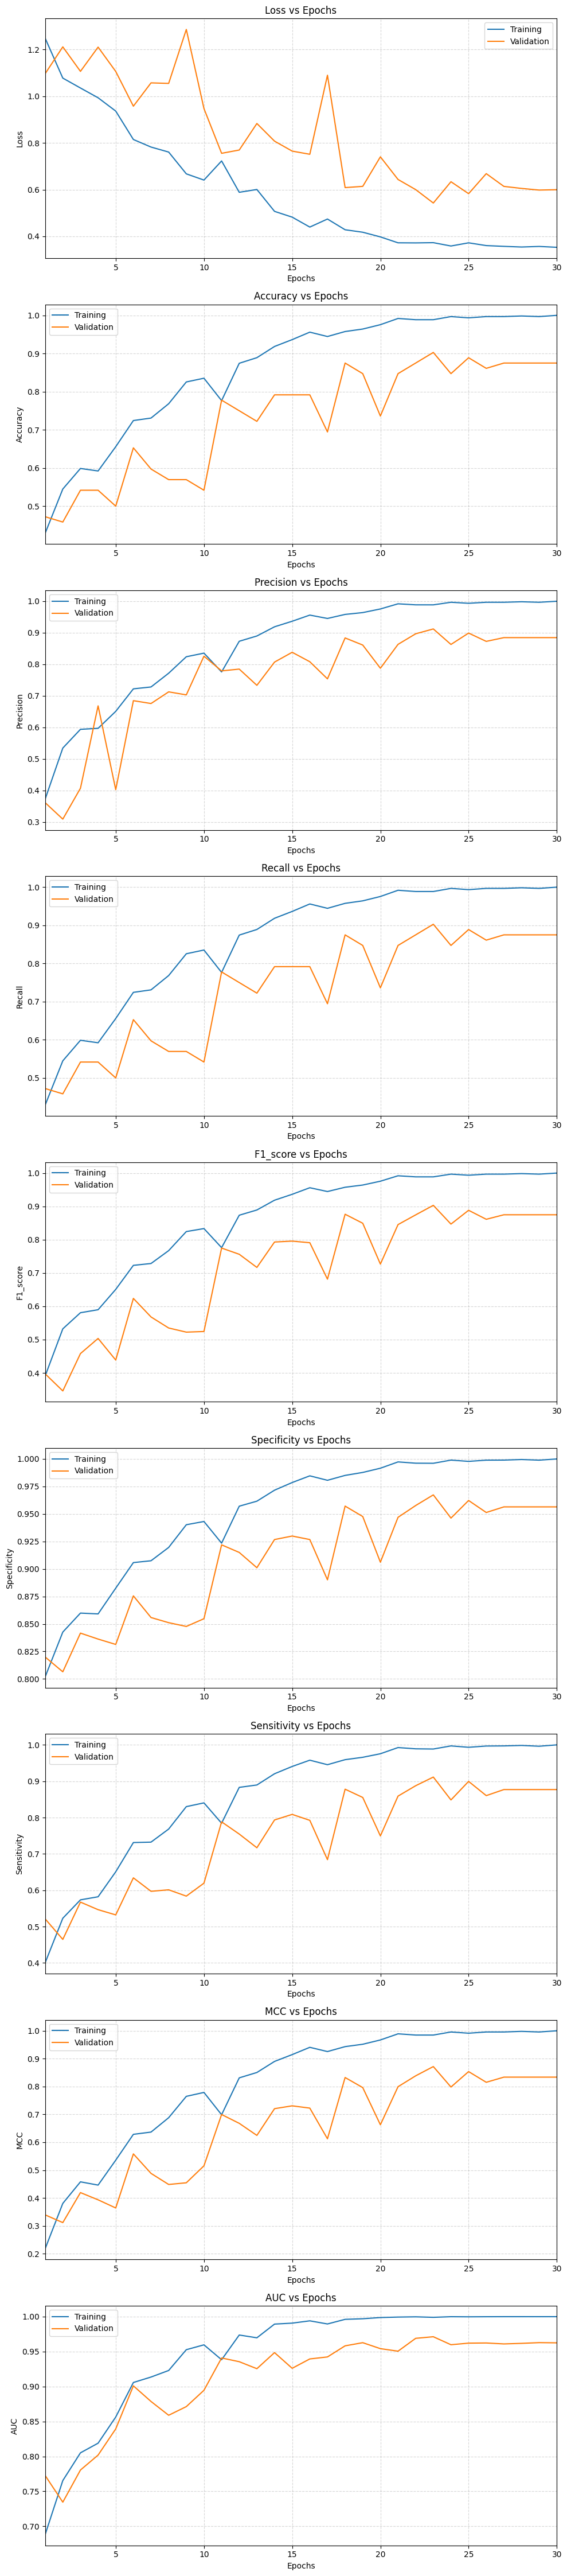

In [14]:
def plot_metrics(train_history, val_history, metric_names):
    num_metrics = len(metric_names)
    num_ep = len(train_history[metric_names[0]])
    figure, axes = plt.subplots(num_metrics, 1, figsize=(10, 5 * num_metrics))
    rng = range(1, num_ep + 1)

    for ax, name in zip(axes, metric_names):
        tr = train_history[name]
        vl = val_history[name]
        ax.plot(rng, tr, label="Training")
        ax.plot(rng, vl, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")
        label = name.upper() if name in ("auc", "mcc") else name.capitalize()
        ax.set_ylabel(label)
        ax.set_title(f"{label} vs Epochs")
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, num_ep)

    plt.tight_layout()
    plt.savefig('/kaggle/working/training_metrics.png', dpi=150)
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)


## Test Evaluation
Loads the best checkpoint saved during training.

In [15]:
# Load best model weights
model.load_state_dict(torch.load('/kaggle/working/best_swin_lungcancer.pth', map_location=device))
model.eval()

total_loss  = 0.0
all_preds   = []
all_targets = []

with torch.no_grad():
    for data, targets in tqdm(test_loader, desc="Testing"):
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        loss    = criterion(outputs, targets)
        total_loss  += loss.item()
        all_preds.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

all_preds   = np.array(all_preds)
all_targets = np.array(all_targets)

avg_loss     = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_preds), torch.tensor(all_targets), avg_loss)

print("=== TEST RESULTS ===")
for k, v in test_metrics.items():
    print(f"  {k:12s}: {v:.4f}")


Testing: 100%|██████████| 10/10 [00:02<00:00,  3.69it/s]

=== TEST RESULTS ===
  loss        : 0.5273
  accuracy    : 0.9111
  precision   : 0.9121
  recall      : 0.9111
  f1_score    : 0.9113
  specificity : 0.9683
  sensitivity : 0.9216
  mcc         : 0.8767
  auc         : 0.9830


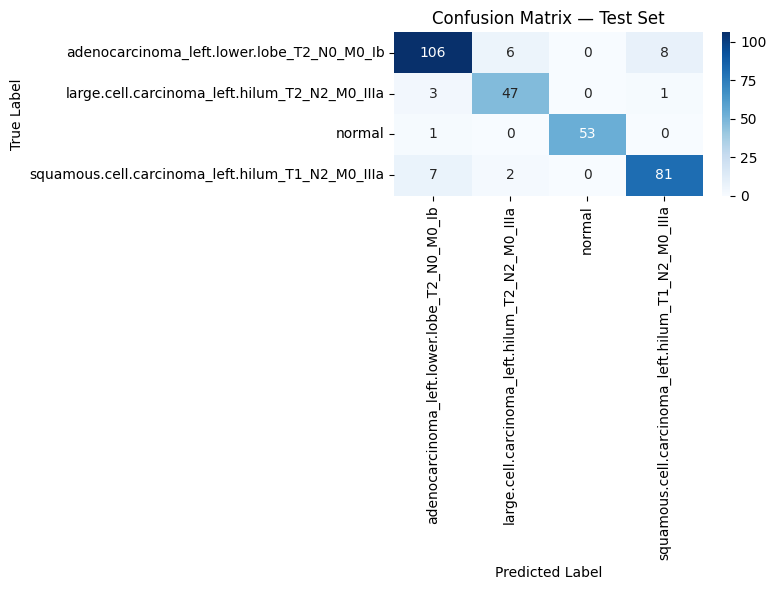


Classification Report:
                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.91      0.88      0.89       120
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       0.85      0.92      0.89        51
                                          normal       1.00      0.98      0.99        54
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.90      0.90      0.90        90

                                        accuracy                           0.91       315
                                       macro avg       0.92      0.92      0.92       315
                                    weighted avg       0.91      0.91      0.91       315



In [16]:
classes = train_ds.classes

y_pred_classes = np.argmax(all_preds, axis=1)
cm = confusion_matrix(all_targets, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix — Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrix.png', dpi=150)
plt.show()

print("\nClassification Report:")
print(classification_report(all_targets, y_pred_classes, target_names=classes))
